# Setup

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
import pandas as pd


sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
prefix = 'bravesouls/unsupervised/title'

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023375022819


arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
sagemaker-us-east-1-023375022819


In [2]:
def prep_data():
    !mkdir Data
    !aws s3 cp s3://aws-ml-chicago-team-bravesouls/amazon_review_polarity_csv.tgz Data
    !tar -xvzf Data/amazon_review_polarity_csv.tgz
#prep_data()

In [8]:
#!head -100000 amazon_review_polarity_csv/train.csv > amazon_review_polarity_csv/train_100k.csv

# Data Processing

In [3]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
def transform_instance(row):
    cur_row = []
    #label = "__label__" + row[0]  #Prefix the index-ed label with __label__
    #cur_row.append(label)
    cur_row.extend(nltk.word_tokenize(row[1].lower()))
    return cur_row

In [5]:
def preprocess(input_file, output_file, keep=1):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    shuffle(all_rows)
    all_rows = all_rows[:int(keep*len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, all_rows)
    pool.close() 
    pool.join()
    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
        csv_writer.writerows(transformed_rows)

In [6]:
%%time
# Preparing the training dataset

# Since preprocessing the whole dataset might take a couple of mintutes,
# we keep 20% of the training dataset for this demo.
# Set keep to 1 if you want to use the complete dataset
#preprocess('/home/ec2-user/SageMaker/blazingtext_text_classification_dbpedia_2019-01-08/amazon_review_polarity_csv/train.csv', 'amazon_review_polarity_title.train', keep=.2)
preprocess('/home/ec2-user/SageMaker/blazingtext_text_classification_dbpedia_2019-01-08/amazon_review_polarity_csv/train.csv', 'amazon_review_polarity_title.train')
        
# Preparing the validation dataset        
#preprocess('/home/ec2-user/SageMaker/blazingtext_text_classification_dbpedia_2019-01-08/amazon_review_polarity_csv/test.csv', 'amazon_review_polarity_title.validation', keep=.2)
#preprocess('/home/ec2-user/SageMaker/blazingtext_text_classification_dbpedia_2019-01-08/amazon_review_polarity_csv/test.csv', 'amazon_review_polarity_title.validation')

CPU times: user 44.9 s, sys: 5.8 s, total: 50.7 s
Wall time: 1min 44s


In [8]:
%%time

train_channel = prefix + '/train'
#validation_channel = prefix + '/validation'

#sess.upload_data(path='text8', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='amazon_review_polarity_title.train', bucket=bucket, key_prefix=train_channel)
#sess.upload_data(path='amazon_review_polarity_title.validation', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
#s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

CPU times: user 672 ms, sys: 420 ms, total: 1.09 s
Wall time: 766 ms


In [9]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [10]:
region_name = boto3.Session().region_name

In [11]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [12]:
#bt_model = sagemaker.estimator.Estimator(container,
#                                         role, 
#                                         base_job_name= "SeanW-BraveSouls-Title",
#                                         train_instance_count=1, 
#                                         train_instance_type='ml.c4.4xlarge',
#                                         train_volume_size = 30,
#                                         train_max_run = 360000,
#                                         input_mode= 'File',
#                                         output_path=s3_output_location,
#                                         sagemaker_session=sess)
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         base_job_name= "SeanW-BraveSouls-Title-Unsupervised",
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [13]:
#bt_model.set_hyperparameters(mode="supervised",
#                            epochs=10,
#                            min_count=2,
#                            learning_rate=0.05,
#                            vector_dim=10,
#                            early_stopping=True,
#                            patience=4,
#                            min_epochs=5,
#                            word_ngrams=2)
bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

In [14]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
#validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
#                             content_type='text/plain', s3_data_type='S3Prefix')

#data_channels = {'train': train_data, 'validation': validation_data}
data_channels = {'train': train_data}

In [15]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: SeanW-BraveSouls-Title-Unsupervised-2019-01-09-19-26-58-809


2019-01-09 19:26:58 Starting - Starting the training job...
2019-01-09 19:27:02 Starting - Launching requested ML instances......
2019-01-09 19:28:07 Starting - Preparing the instances for training......
2019-01-09 19:29:15 Downloading - Downloading input data
2019-01-09 19:29:15 Training - Training image download completed. Training in progress.
Arguments: train
Found 10.32.0.5 for host algo-1
Arguments: train
Found 10.32.0.5 for host algo-1
Found 10.40.0.4 for host algo-2
Found 10.40.0.4 for host algo-2
[01/09/2019 19:29:27 WARNING 140262355179328] Loggers have already been setup.
[01/09/2019 19:29:27 WARNING 140262355179328] Loggers have already been setup.
[01/09/2019 19:29:27 INFO 140262355179328] nvidia-smi took: 0.0252358913422 secs to identify 0 gpus
[01/09/2019 19:29:27 INFO 140262355179328] Running distributed CPU BlazingText training using batch_skipgram on 2 hosts.
[01/09/2019 19:29:27 INFO 140262355179328] Number of hosts: 2, master IP address: 10.32.0.5, host IP address: 

In [16]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2019-01-09-19-32-29-583
INFO:sagemaker:Creating endpoint with name SeanW-BraveSouls-Title-Unsupervised-2019-01-09-19-26-58-809


---------------------------------------------------------------!

In [17]:
sentences = ["This product sucks",
            "A very good buy. I really recommend",
            "Bad design. Very hard to use",
            "I'm very satisfied. The best buy ever!!",
             "I would have loved this thing but it didn't have enough pixels",
             "I would have loved this thing but...",
             "I hate to love this thing, but I do",
             "I love to hate this thing, but I don't"
    ]


# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances" : tokenized_sentences}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
#print(json.dumps(predictions, indent=2))
print(predictions)


[{'vector': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'word': 'This product sucks'}, {'vector': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [18]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

In [19]:
!tar -xvzf model.tar.gz

vectors.txt
vectors.bin
eval.json


In [20]:
!cat eval.json

{
    "EN-WS-353-ALL.txt": {
        "not_found": 22, 
        "spearmans_rho": 0.45389691531972365, 
        "total_pairs": 353
    }, 
    "EN-WS-353-REL.txt": {
        "not_found": 14, 
        "spearmans_rho": 0.3485170294509767, 
        "total_pairs": 252
    }, 
    "EN-WS-353-SIM.txt": {
        "not_found": 10, 
        "spearmans_rho": 0.5295109911969812, 
        "total_pairs": 203
    }, 
    "mean_rho": 0.4439749786558938
}

In [21]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

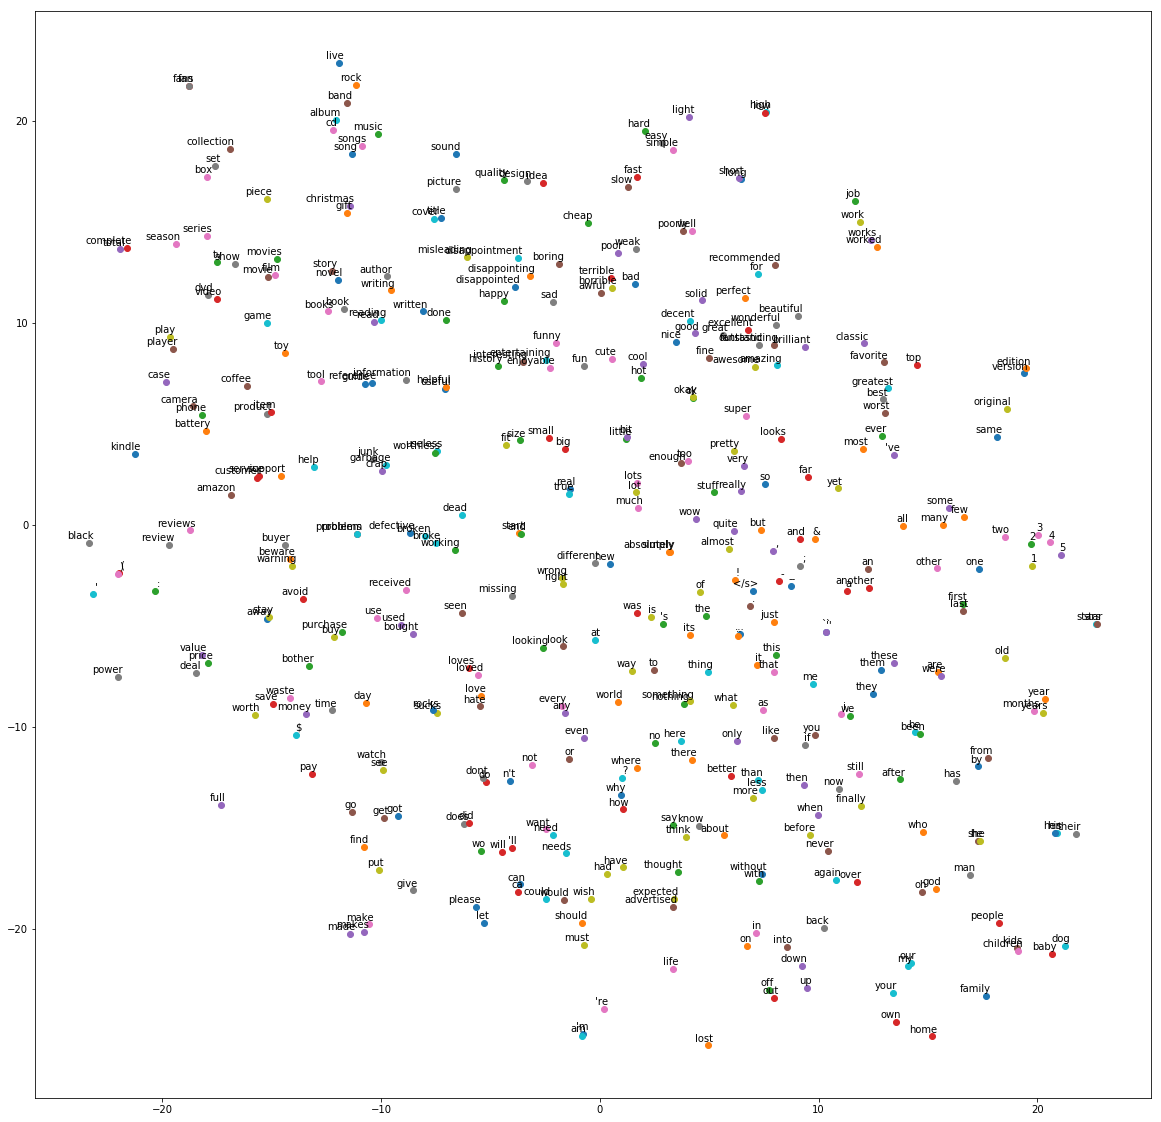

In [23]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)

In [24]:
sess.delete_endpoint(bt_endpoint.endpoint)

NameError: name 'bt_endpoint' is not defined